# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 5: the BH primary mass distribution

1. for several redshift bins
2. normalized by the peak rate to emphazise the change in the shape


## Imports and definitions:

In [1]:
######################################
## Imports
import numpy as np
import h5py as h5

from astropy.table import Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm

from scipy import stats

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# Extra python functions
import HelperFunctions as func

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 


In [2]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
DCO.info()
'''

################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
# DCO['Metallicity@ZAMS(1)']   = File['DoubleCompactObjects']['Metallicity@ZAMS(1)'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])
# DCO['mixture_weight']        = File['DoubleCompactObjects']['mixture_weight'][()]

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
intrinsic_rate_density       = File[rate_key]['merger_rate'][()]
redshifts                    = File[rate_key]['redshifts'][()]

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16

# Filter both the BBH table and the intrinsic rate data
merging_BBH         = DCO[DCO_mask * nonCHE_bool]
Red_intr_rate_dens  = intrinsic_rate_density[rate_nonCHE_bool, :]


../output/COMPAS_Output_wWeights.h5


# Mass dist split by redshift

In [8]:
# Distribution plot function
def plot_dist_by_redshift(table, x_key, WEIGHTS, log = False, kde_width = 0.1, 
                          bootstrap  = False, bootstraps = 100,
                          redshift_list = redshifts, fill=True, show_hist = False,
                          normalize_by_peak = False, annotate_stuff=True,
                          bins = np.arange(0,50,2),  z_bin_edges = [1,2,3,4],
                          savestr = '', save_plot=False, x_lim=(0,50), y_lim = (0,1000), 
                          colors = ['#488496', '#73bdb3', '#e388b0'],
                          xlabel = '$M_{\mathrm{BH,1} \ } [\mathrm{M_{\odot}} ]$',
                          ylabel = r'$R_{\mathrm{BBH} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$',
                         leg_args = None):
    
    #########################################
    mass_binw = np.diff(bins)[0]
    
    #########################################
    # centers of redshif bins
    center_z = (redshift_list[:-1] + redshift_list[1:])/2.
    #Centers of your crude redshift bins
    center_Crude_bins = (z_bin_edges[:-1] + z_bin_edges[1:])/2. # center points

    ##############################
    ## Calculate average rate density per z-bin
    crude_rate_density = func.get_crude_rate_density(WEIGHTS, redshift_list, z_bin_edges)

    # If you want to re-normalize the dist
    norm = 1.
    
    #########################################
    # labels based on z_bin_edges
    labels     = ['$%s \leq z < %s$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1) ]
    labels[0]  = '$z < %s$'%(z_bin_edges[1])
    labels.append('$z \geq %s$'%(z_bin_edges[-1]))


    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = (12, 8))


    #########################################
    for i in range(len(center_Crude_bins)):
        print('crude bin i = ', i)
        # X value and weight
        x_vals = table[x_key]
        m_Weight     = crude_rate_density[:,i]
        
        ########################
        # Get the Hist    
        hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
        center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
        # And the KDE
        kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=m_Weight)
        binwidth = np.diff(bin_edge)
        
        if normalize_by_peak:
            norm = max(hist/mass_binw)
        
        ########################
        # Plot the Hist 
        if show_hist:
            y_vals = hist/mass_binw/norm
            ax.bar(center_bins, y_vals, width= np.diff(bins), 
                   alpha=1.0, fill=False, edgecolor=colors[i],lw = 1., zorder = i) 
            print('sum(hist)', sum(hist), 'sum(hist*mass_binw)', sum(hist*mass_binw) )

        ########################
        # Add KDE
        show_KDE = True
        if show_KDE:
            x_KDE = np.arange(2.5,bins[-1],0.1)
            KDEy_vals = kernel(x_KDE)*sum(hist)/norm #re-normalize the KDE
            ax.plot(x_KDE, KDEy_vals,label = labels[i],  color=colors[i], lw=5,  zorder =i+1)
            if fill:
                ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, color=colors[i], alpha = 0.05, zorder = i+1)

            
        ########################
        # Bootstrap        
        if bootstrap:
            indices = np.arange(len(x_vals))
            hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
            for b in range(len(hist_vals)):
                print('boostrap b=', b)

                boot_index = np.random.choice(indices, size=len(indices), replace=True)

                kernel       = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights=m_Weight[boot_index])
                Hist, _      = np.histogram(x_vals[boot_index], bins=bins,weights=m_Weight[boot_index],density=False)

                norm         = max(Hist/mass_binw)

                hist_vals[b] = kernel(x_KDE)*sum(Hist)/norm
                
            # calculate 1- and 2- sigma percentiles
            percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
            median = np.percentile(hist_vals, [50], axis=0)

            # plot uncertainties as filled areas
            ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors[i], zorder = 11) # 1-sigma
            ax.fill_between(x_KDE, percentiles[2], percentiles[3],alpha=0.2, color=colors[i], zorder = 10) # 2-sgima    

    
    # annotate where all the peaks should be
    if annotate_stuff:
        ax.annotate(text='$\mathrm{peak \ rate}$',  xy=(15, 4e1), xytext = (6.5, 4e1), #xy=(15, 8.5e2), xytext = (6.5, 1.15e3), 
                    arrowprops=dict(facecolor='grey', arrowstyle='->'), rotation=0, color = 'k', size = 20)        
        ax.annotate(text='$\mathrm{transition \ CCSN - PPISN}$', xy=(33, 2e0), xytext = (25, 2e1), #xy=(33, 8e1), xytext = (25, 5e2), 
                    arrowprops=dict(facecolor='grey',  arrowstyle='->'), size = 20, color = 'k')
        
        ax.annotate(text='$\mathrm{PPISN \ pile-up}$',  ha='center', xy=(44, 8e-1), xytext = (43, 5e0),#xy=(44, 2e1), xytext = (43, 8e1),
                    arrowprops=dict(facecolor='grey',  arrowstyle='->'), size = 20, color = 'k')

    #########################################
    # plot values
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    leg = ax.legend(fontsize = 22, **leg_args)


    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    if log:
        ax.set_yscale('log')
        
    if save_plot:
        plt.savefig(save_loc+'/'+savestr+'Mass_dist_by_redshift.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/'+savestr+'Mass_dist_by_redshift.png', bbox_inches='tight')

    plt.show()


    

i_per_crude_bin 40.0
crude bin i =  0
crude bin i =  1
crude bin i =  2
crude bin i =  3
crude bin i =  4


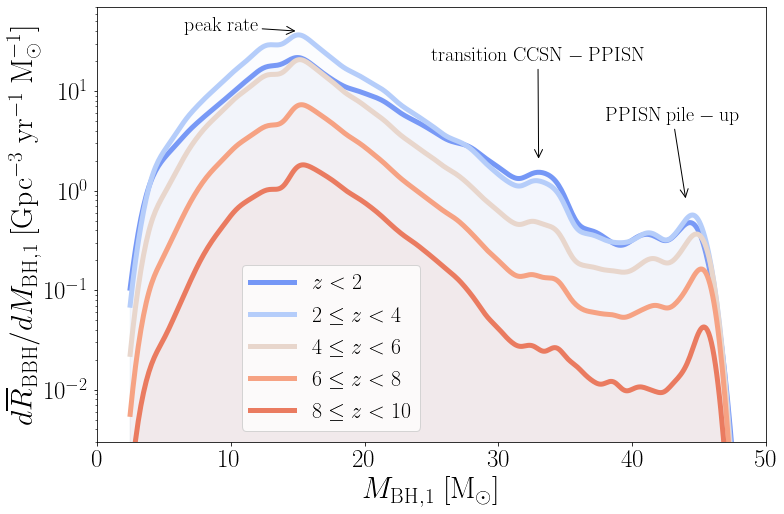

In [10]:
kleuren = sns.color_palette("coolwarm", 10)

#Full z range
indexes = [1,3,5,7,8,9]
plot_dist_by_redshift(merging_BBH, 'M_moreMassive', Red_intr_rate_dens, normalize_by_peak = False,
                      bootstrap  = False, bootstraps = 50,
                      bins = np.arange(0,50,1),
                      colors = [kleuren[e] for e in indexes], y_lim = (3e-3,7e1), z_bin_edges = np.array([0,2,4,6,8,10]),
                      log = True, savestr = sim_save_str+'log', save_plot=True, 
                      show_hist = False, annotate_stuff=True,
                      ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                      leg_args = {'bbox_to_anchor':(0.2,0.), 'loc':'lower left'})




i_per_crude_bin 10.0
crude bin i =  0
crude bin i =  1
crude bin i =  2
crude bin i =  3


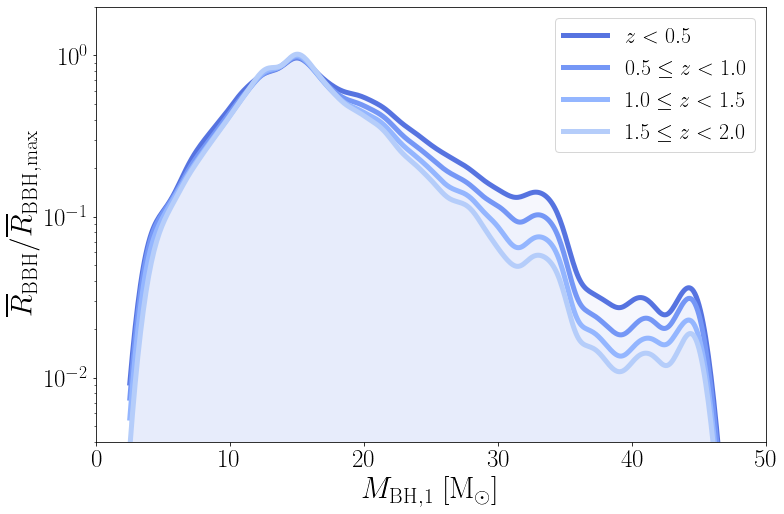

In [9]:
kleuren = sns.color_palette("coolwarm", 10)

#Lower redshifts, normalized by peak
indexes = [0,1,2,3,5]
plot_dist_by_redshift(merging_BBH, 'M_moreMassive', Red_intr_rate_dens, normalize_by_peak = True,
                      annotate_stuff=False, bootstrap  = False, bootstraps = 1,  
                      bins = np.arange(0,50,1.),
                      fill = True, ylabel = r'$\overline{R}_{\mathrm{BBH}}/\overline{R}_{\mathrm{BBH, max}}$',
                      colors = [kleuren[e] for e in indexes], y_lim = (4e-3,2), z_bin_edges = np.array([0,0.5,1,1.5,2]), #z_bin_edges = [1,2,3,4],
                      log = True, savestr = sim_save_str+'_normed_', save_plot=True,
                     leg_args = {'loc':'upper right'})
